In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
shapefile_path = 'data/hydrobasins_lvl6/hybas_as_lev06_v1c.shp'
shapes = gpd.read_file(shapefile_path)

<Axes: >

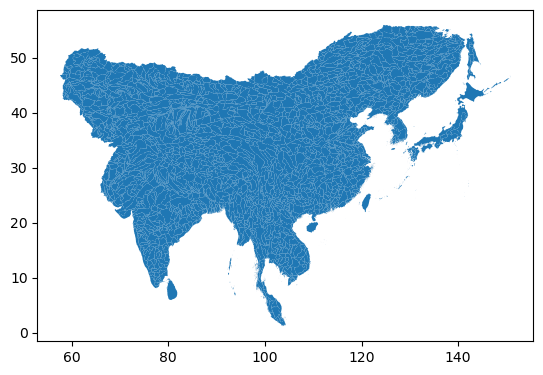

In [3]:
shapes.plot()

In [4]:
def get_precip_data_for_year(data_path, shapes):
    dataset = xr.open_dataset(data_path)
    
    sums = []
    
    for index, shape in shapes.iterrows():
        # Extract the geometry
        geom = shape.geometry

        # Select the data from the NetCDF file using the geometry
        # because \nearest\ method is used, even if there is no data
        # , it will calculate an average for data nearest to it
        # this makes it appear like there is data for areas where there is none (e.g., in Japan).
        # TODO : needs to label whether a shape is part of tibetan plateau or not
        data = dataset.sel(longitude=geom.centroid.x, latitude=geom.centroid.y, method='nearest')
        # data = dataset.sel(longitude=geom.centroid.x, latitude=geom.centroid.y, method=None)

        # Calculate the sum of the data
        # data_sum = data.sum()
        data_sum = data.sum()['tp'].values

        # Append the sum to the list
        sums.append(data_sum)
        
    return sums


In [5]:
years = np.arange(1984, 2022, 1)

final_data_set = pd.DataFrame()

for year in years:
    precip = get_precip_data_for_year(f'data/precip/{year}/data.nc', shapes=shapes)
    year_df = pd.DataFrame()
    year_df['precip'] = precip
    year_df['precip'] = year_df['precip'].astype(np.float64)
    year_df['year'] = year
    final_data_set = pd.concat([final_data_set, year_df])
    
final_data_set.head()

,precip,year
0,0.143784,1984
1,0.143784,1984
2,0.143784,1984
3,0.143784,1984
4,0.143784,1984


In [6]:
# Calculate the centroid of each shape and add a marker to the map
shapes['centroid_lon'] = shapes.apply(lambda row: row['geometry'].centroid.x, axis=1)
shapes['centroid_lat'] = shapes.apply(lambda row: row['geometry'].centroid.y, axis=1)


In [7]:
final_data_set = final_data_set.join(shapes).sort_values(by=['year', 'SORT'])
final_data_set = gpd.GeoDataFrame(final_data_set)

# bounding box from precip data
xmin = 45
xmax = 107
ymin = 24
ymax = 68

final_data_set = final_data_set.cx[xmin:xmax, ymin:ymax]


final_data_set.describe()
final_data_set.head()

,precip,year,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,centroid_lon,centroid_lat
447,1.206194,1984,4060631960,4060629690,4060007850,4060007850,1356.8,1356.8,28426.8,51783.5,432270,0,0,2,448,"POLYGON ((108.86667 34.43750, 108.88138 34.438...",107.535213,34.395430
451,0.880377,1984,4060611660,4060631880,4060007850,4060007850,1527.2,1527.2,4221.8,4222.0,432262,0,0,4,452,"POLYGON ((106.58750 35.12083, 106.58807 35.127...",107.389148,35.047425
453,0.778580,1984,4060606120,4060611300,4060007850,4060007850,1552.4,1552.4,14418.8,14418.8,432264,0,0,4,454,"POLYGON ((107.41667 35.30000, 107.40174 35.300...",106.924689,35.716825
462,0.695534,1984,4060583100,4060606020,4060007850,4060007850,1649.8,1649.8,5961.4,10598.4,432267,0,0,3,463,"POLYGON ((107.67917 36.41667, 107.67981 36.410...",107.294046,36.419078
472,0.778336,1984,4060625230,4060631960,4060007850,4060007850,1753.2,1753.2,10713.7,10713.7,432290,0,0,2,473,"POLYGON ((106.29583 35.29167, 106.30662 35.291...",105.759122,35.404014


<Axes: >

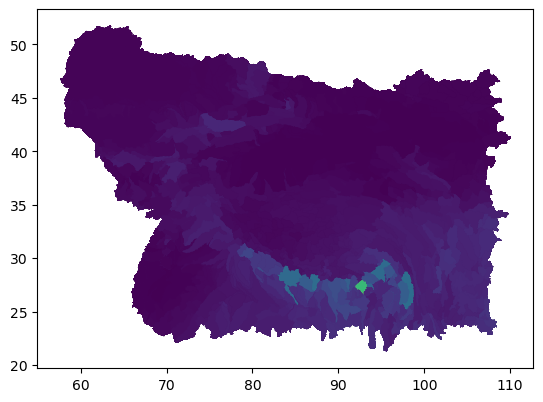

In [8]:
final_data_set.plot('precip')

In [9]:
final_data_set.HYBAS_ID.unique().shape

(1185,)

In [10]:
final_data_set.groupby('year').count()

,precip,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,PFAF_ID,ENDO,COAST,ORDER,SORT,geometry,centroid_lon,centroid_lat
year,,,,,,,,,,,,,,,,,
1984,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1985,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1986,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1987,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1988,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1989,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1990,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1991,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185
1992,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185,1185


In [11]:
# lake_df = pd.read_csv('data/gsw_reduced/lake_data.csv')
lake_df = pd.read_csv('/Users/johnaiken/repos/tblakes/data/lake_data.csv')
lake_df.head()

,Unnamed: 0,HYBAS_ID,lake_growth,lake_decline,all,year,region,growth_ratio,decline_ratio,water_balance,water_balance_m3
0,0,4060050470,131593.043137,-75959.117647,3.822362e+07,2001,1,0.003443,0.001987,207552.160784,186.796945
1,7024,4060685650,5658.352941,-3593.000000,3.436465e+07,2001,4,0.000165,0.000105,9251.352941,8.326218
2,7023,4060623190,3181.278431,-711.000000,6.995463e+06,2001,4,0.000455,0.000102,3892.278431,3.503051
3,7022,4060607420,1443.686275,-544.811765,2.884887e+06,2001,4,0.000500,0.000189,1988.498039,1.789648
4,7021,4060603790,556.109804,-20.000000,7.101565e+05,2001,4,0.000783,0.000028,576.109804,0.518499


In [12]:
lake_df.groupby([ 'year']).count()

,Unnamed: 0,HYBAS_ID,lake_growth,lake_decline,all,region,growth_ratio,decline_ratio,water_balance,water_balance_m3
year,,,,,,,,,,
2001,592,592,592,592,592,592,592,592,592,592
2002,592,592,592,592,592,592,592,592,592,592
2003,592,592,592,592,592,592,592,592,592,592
2004,592,592,592,592,592,592,592,592,592,592
2005,592,592,592,592,592,592,592,592,592,592
2006,592,592,592,592,592,592,592,592,592,592
2007,592,592,592,592,592,592,592,592,592,592
2008,592,592,592,592,592,592,592,592,592,592
2009,592,592,592,592,592,592,592,592,592,592


In [13]:
lake_df[lake_df.year==2001].HYBAS_ID.unique().shape

(477,)

In [14]:
lake_df[lake_df.year==2002].HYBAS_ID.unique().shape

(477,)

In [15]:
# fds.dtypes

In [16]:
# lake_df.dtypes

In [17]:
year = 2015
fds = final_data_set[final_data_set.year==year].copy()
print('precip data shape', fds.HYBAS_ID.unique().shape)
ldf = lake_df[lake_df.year==year].copy()
print('lake data shape', ldf.HYBAS_ID.unique().shape)
fds.merge(lake_df[lake_df.year==year], on='HYBAS_ID').HYBAS_ID.unique().shape

precip data shape (1185,)
lake data shape (477,)


(477,)

In [18]:
df = final_data_set.merge(lake_df, on=['HYBAS_ID', 'year'])

<Axes: >

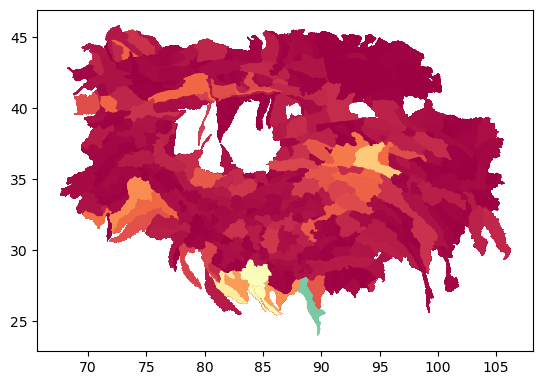

In [19]:
df.plot('water_balance_m3', cmap='Spectral')


(0.0, 1.0)

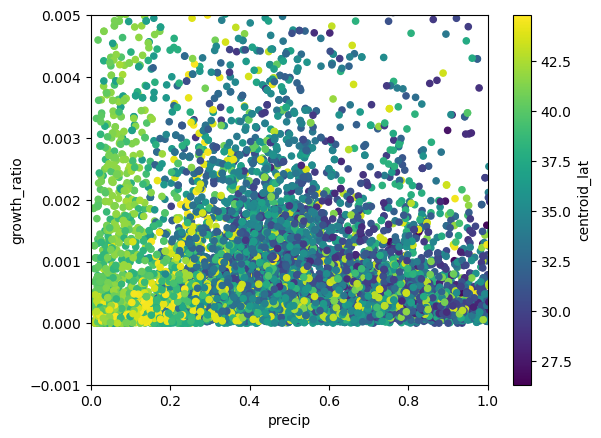

In [20]:
ax = df.plot.scatter('precip', 'growth_ratio', c='centroid_lat')
ax.set_ylim(-0.001, 0.005)
ax.set_xlim(0, 1)

In [21]:
df

,precip,year,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,...,centroid_lat,Unnamed: 0,lake_growth,lake_decline,all,region,growth_ratio,decline_ratio,water_balance,water_balance_m3
0,0.628334,2001,4060625490,4060631960,4060007850,4060007850,1753.3,1753.3,12643.3,12643.3,...,34.883571,1975,412.000000,-390.000000,1.716384e+07,13,0.000024,0.000023,802.000000,0.721800
1,0.628334,2001,4060625490,4060631960,4060007850,4060007850,1753.3,1753.3,12643.3,12643.3,...,34.883571,4252,412.000000,-390.000000,1.716384e+07,17,0.000024,0.000023,802.000000,0.721800
2,0.378130,2001,4060534090,4060516030,4060007850,4060007850,3002.4,3002.4,19623.9,261233.7,...,37.202176,1953,9707.756863,-6844.419608,2.743681e+07,13,0.000354,0.000249,16552.176471,14.896959
3,0.332055,2001,4060563950,4060534090,4060007850,4060007850,3277.0,3277.0,14968.8,232183.9,...,36.473564,1954,2078.000000,-2619.000000,2.073012e+07,13,0.000100,0.000126,4697.000000,4.227300
4,0.415063,2001,4060578830,4060563950,4060007850,4060007850,3462.8,3462.8,1244.3,184333.3,...,36.019665,1955,770.749020,-418.992157,1.713215e+06,13,0.000450,0.000245,1189.741176,1.070767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11243,0.615744,2019,4060061740,4060785160,4060061740,4060025450,0.0,2555.1,533.2,533.2,...,29.043773,5063,721.760784,-2534.000000,6.791608e+05,18,0.001063,0.003731,3255.760784,2.930185
11244,0.275851,2019,4060062620,0,4060062620,4060062620,0.0,0.0,445.9,445.9,...,37.724492,1360,0.000000,-1.000000,6.278207e+05,10,0.000000,0.000002,1.000000,0.000900
11245,0.049032,2019,4060062830,0,4060062830,4060062830,0.0,0.0,762.2,762.2,...,40.985435,11246,10.000000,-890.000000,1.124369e+06,9,0.000009,0.000792,900.000000,0.810000
11246,0.698952,2019,4060066240,4060589340,4060066240,4060007850,0.0,3531.5,192.8,192.9,...,36.377218,2703,117.000000,-28.000000,2.666746e+05,13,0.000439,0.000105,145.000000,0.130500


/var/folders/20/67zvnfrd4qn0q8029j2qbpqw0000gn/T/ipykernel_17940/862849438.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sums = df.groupby('year').sum()


<Axes: xlabel='year'>

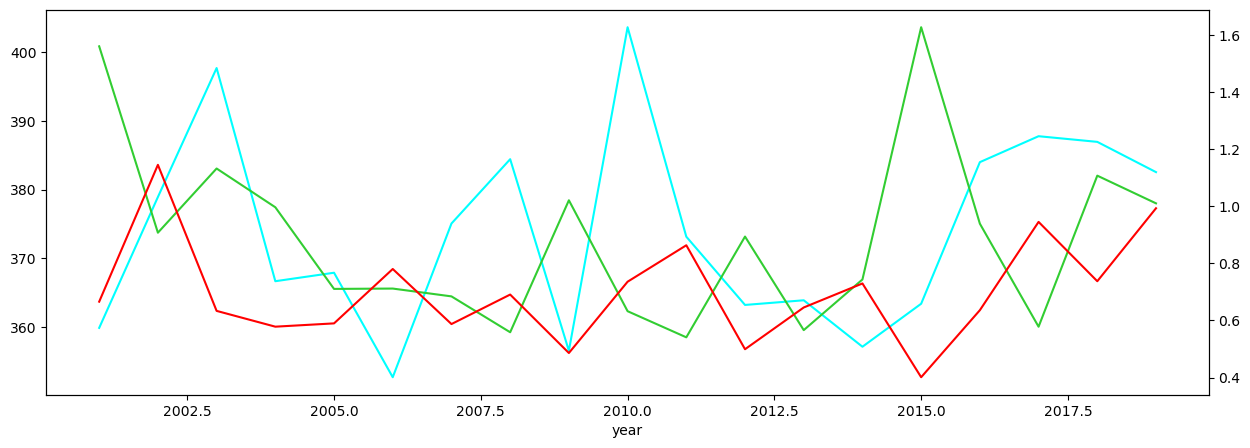

In [22]:
sums = df.groupby('year').sum()

# sums.cumsum().precip.plot()
fig, ax = plt.subplots(figsize=(15, 5))
sums.precip.plot(ax=ax, color='cyan')
ax2 = ax.twinx()
sums.growth_ratio.plot(ax=ax2, color='limegreen')
sums.decline_ratio.plot(ax=ax2, color='red')

In [23]:
df['all'].apply(lambda row: (row * 30 * 30)/1e3**2)

0        15447.455449
1        15447.455449
2        24693.129579
3        18657.108914
4         1541.893553
             ...     
11243      611.244695
11244      565.038639
11245     1011.932368
11246      240.007129
11247      299.894735
Name: all, Length: 11248, dtype: float64

In [24]:
df.columns

Index(['precip', 'year', 'HYBAS_ID', 'NEXT_DOWN', 'NEXT_SINK', 'MAIN_BAS',
       'DIST_SINK', 'DIST_MAIN', 'SUB_AREA', 'UP_AREA', 'PFAF_ID', 'ENDO',
       'COAST', 'ORDER', 'SORT', 'geometry', 'centroid_lon', 'centroid_lat',
       'Unnamed: 0', 'lake_growth', 'lake_decline', 'all', 'region',
       'growth_ratio', 'decline_ratio', 'water_balance', 'water_balance_m3'],
      dtype='object')

<Axes: xlabel='SUB_AREA', ylabel='all'>

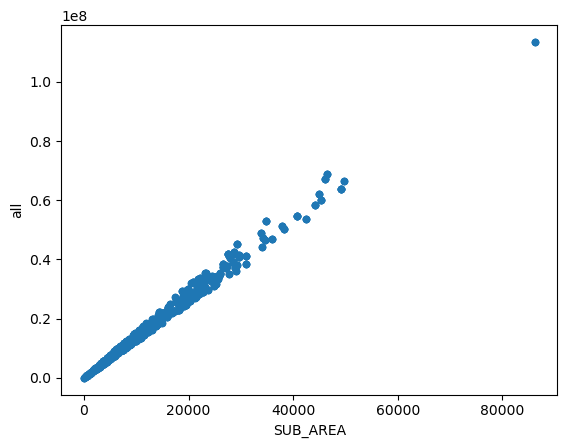

In [25]:
df[['SUB_AREA', 'all']].drop_duplicates().plot.scatter('SUB_AREA', 'all')

In [26]:
df.describe()

,precip,year,HYBAS_ID,NEXT_DOWN,NEXT_SINK,MAIN_BAS,DIST_SINK,DIST_MAIN,SUB_AREA,UP_AREA,...,centroid_lat,Unnamed: 0,lake_growth,lake_decline,all,region,growth_ratio,decline_ratio,water_balance,water_balance_m3
count,11248.000000,11248.000000,1.124800e+04,1.124800e+04,1.124800e+04,1.124800e+04,11248.000000,11248.000000,11248.000000,11248.000000,...,11248.000000,11248.000000,11248.000000,11248.000000,1.124800e+04,11248.000000,11248.000000,11248.000000,1.124800e+04,11248.000000
mean,0.631735,2010.000000,4.060428e+09,2.949419e+09,4.060040e+09,4.060039e+09,1386.534122,1451.139696,11590.156757,35295.127196,...,35.697840,5623.500000,19756.849397,-15845.720504,1.596903e+07,9.170608,0.001505,0.001187,3.560257e+04,32.042313
std,0.726170,5.477469,2.879010e+05,1.810419e+09,1.561787e+04,1.586414e+04,1427.553916,1424.822379,11186.479425,78406.210199,...,4.727272,3247.162248,46776.641810,39845.156894,1.524281e+07,5.545784,0.006193,0.003425,7.595964e+04,68.363673
min,0.006425,2001.000000,4.060050e+09,0.000000e+00,4.060008e+09,4.060008e+09,0.000000,0.000000,2.400000,192.900000,...,26.326715,0.000000,0.000000,-843435.784314,3.405686e+03,1.000000,0.000000,-0.000000,0.000000e+00,0.000000
25%,0.286228,2005.000000,4.060054e+09,0.000000e+00,4.060025e+09,4.060025e+09,0.000000,0.000000,4371.450000,5547.400000,...,32.013153,2811.750000,1653.691176,-13896.055882,5.948182e+06,4.000000,0.000203,0.000156,3.662381e+03,3.296143
50%,0.479668,2010.000000,4.060464e+09,4.060482e+09,4.060050e+09,4.060050e+09,1020.200000,1128.500000,7968.050000,12435.800000,...,35.179326,5623.500000,5771.243137,-4393.601961,1.091539e+07,8.000000,0.000538,0.000424,1.190412e+04,10.713704
75%,0.781301,2015.000000,4.060674e+09,4.060715e+09,4.060051e+09,4.060051e+09,2413.200000,2452.175000,16000.300000,27421.050000,...,39.755218,8435.250000,17963.264706,-1307.750000,2.222542e+07,14.000000,0.001333,0.000990,3.393743e+04,30.543685
max,12.461029,2019.000000,4.060956e+09,4.060972e+09,4.060067e+09,4.060063e+09,5576.800000,5576.800000,86190.400000,767613.700000,...,44.775474,11247.000000,819238.572549,0.000000,1.134426e+08,19.000000,0.433466,0.157136,1.410511e+06,1269.459540


In [27]:
df.year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])

<Axes: >

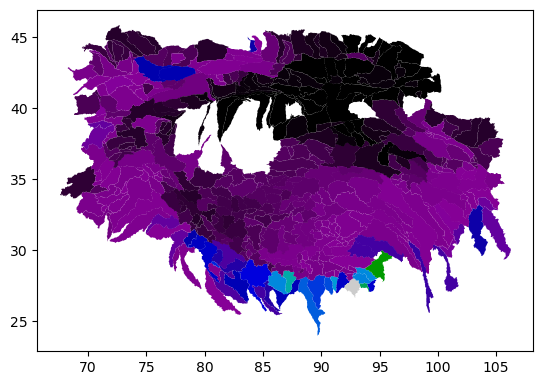

In [33]:
df[df.year==2001].plot('precip', cmap='nipy_spectral')

<Axes: >

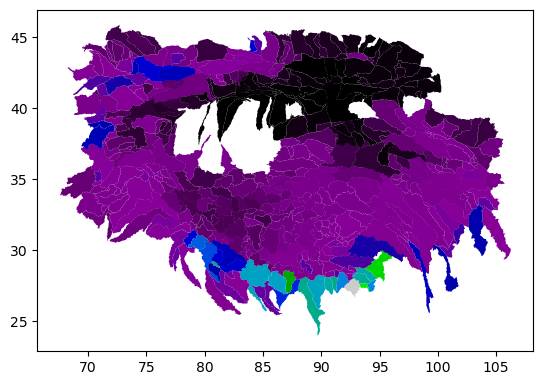

In [34]:
df[df.year==2002].plot('precip', cmap='nipy_spectral')

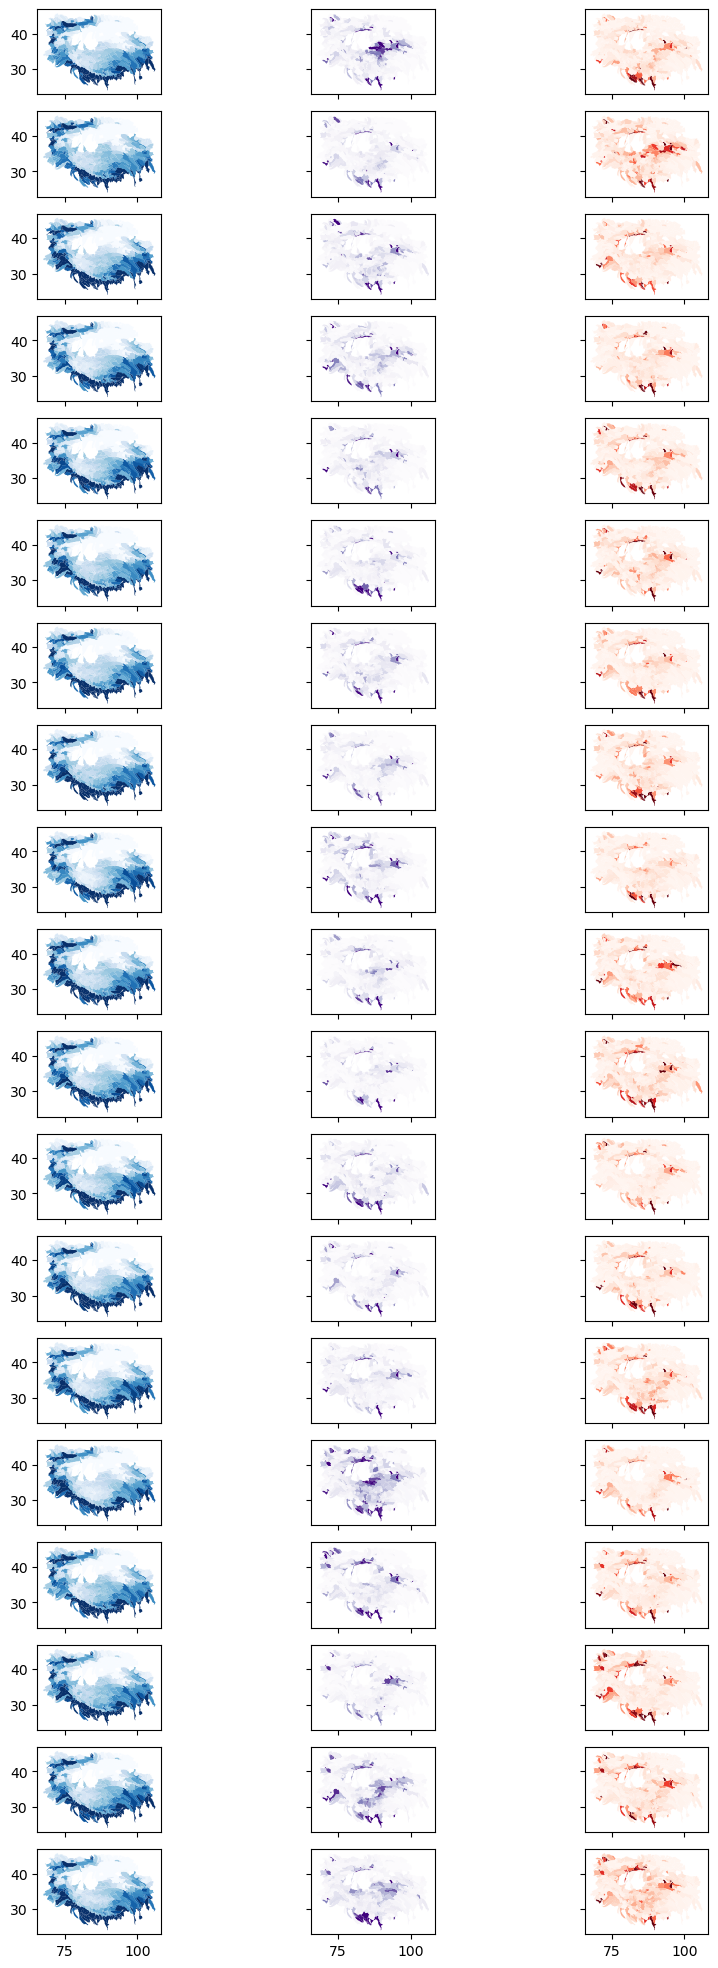

In [36]:
fig, axes = plt.subplots(19, 3, figsize=(10, 25), sharex=True, sharey=True)

for n, ax in enumerate(axes):
    year = 2001 + n
    df[df.year==year].plot('precip', ax=ax[0], cmap='Blues', vmin=0.1, vmax=1.2)
    df[df.year==year].plot('growth_ratio', ax=ax[1], cmap='Purples', vmin=1e-4, vmax=1e-2)
    df[df.year==year].plot('decline_ratio', ax=ax[2], cmap='Reds', vmin=1e-4, vmax=1e-2)

IndexError: index 16 is out of bounds for axis 0 with size 16

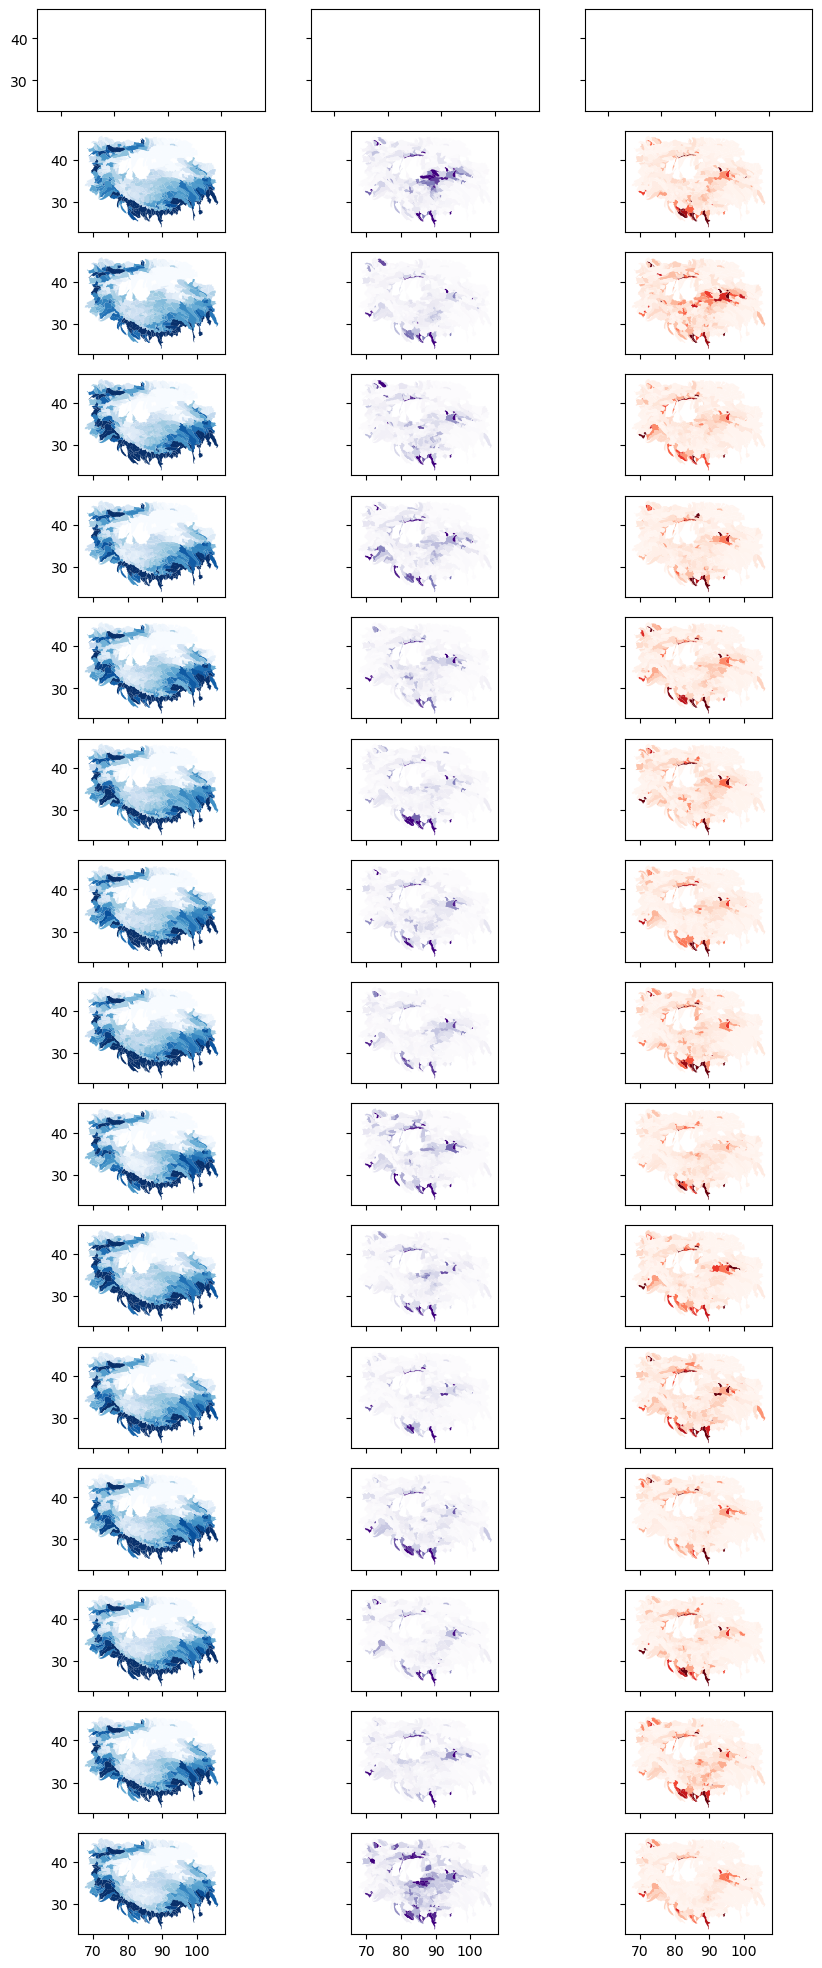

In [31]:
fig, ax = plt.subplots(16, 3, figsize=(10, 25), sharex=True, sharey=True)
# ax = ax.flatten()
for year in df.year.unique()[:-2]:
    # print(year, year-2001)
    df[df.year==year].plot('precip', ax=ax[year-2000][0], cmap='Blues', vmin=0.1, vmax=1.2)
    df[df.year==year].plot('growth_ratio', ax=ax[year-2000][1], cmap='Purples', vmin=1e-4, vmax=1e-2)
    df[df.year==year].plot('decline_ratio', ax=ax[year-2000][2], cmap='Reds', vmin=1e-4, vmax=1e-2)

fig.tight_layout()

In [ ]:
# ax.shape

In [ ]:
# year

In [ ]:
# df.year.unique()